In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


/Users/kwklun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Function to load and prepare data
def load_and_prepare_data():
    msf = pd.read_parquet('data_trimmed/crsp.msf_small.parquet')
    msf['date'] = pd.to_datetime(msf['date'])
    msf['mktcap'] = msf['prc'].abs() * msf['shrout']
    msf['ret'] = msf['ret'].fillna(0)
    msf = msf.sort_values('date')
    return msf

# Load data
data = load_and_prepare_data()
data.head()


,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,...,bid,ask,shrout,cfacpr,cfacshr,altprc,spread,altprcdt,retx,mktcap
15047,92199090,15157,22585,0,1,2254.0,1925-12-31,NaN,NaN,-19.250,...,18.500,20.000,80.0,8.567335,4.957200,-19.250,1.5,1925-12-31,NaN,1540.0
69861,00299090,10022,22158,0,1,3420.0,1925-12-31,NaN,NaN,56.000,...,56.000,56.250,200.0,9.365437,9.365437,56.000,NaN,1925-12-31,NaN,11200.0
9123,91299190,15093,22579,0,1,2080.0,1925-12-31,NaN,NaN,74.625,...,74.625,74.875,240.0,1.060271,1.000000,74.625,NaN,1925-12-31,NaN,17910.0
12003,91399590,15122,22582,0,1,3430.0,1925-12-31,NaN,NaN,28.000,...,27.500,28.000,292.0,1.000000,1.000000,28.000,NaN,1925-12-31,NaN,8176.0
67094,00147610,10014,22157,0,1,3714.0,1925-12-31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.875,NaN,1926-01-04,NaN,NaN


In [3]:
def calculate_metrics(returns, portfolio_values):
    if portfolio_values.isna().all() or len(portfolio_values) == 0:
        print("Warning: Portfolio values contain only NaN.")
        return np.nan, np.nan, np.nan  # Avoid NaN errors

    sharpe = np.nanmean(returns) / np.nanstd(returns) * np.sqrt(12) if np.nanstd(returns) > 0 else np.nan
    cum_returns = (portfolio_values / portfolio_values.iloc[0] - 1) * 100  # Ensure first value is valid
    
    roll_max = portfolio_values.cummax()
    drawdowns = portfolio_values / roll_max - 1
    max_drawdown = drawdowns.min() * 100  # Convert to percentage

    return sharpe, cum_returns.iloc[-1], max_drawdown  # Ensure valid return


In [4]:
# Function to compute Buy and Hold Strategy
def buy_and_hold_strategy(data, initial_investment=10000):
    total_mktcap = data.groupby('date')['mktcap'].sum()
    portfolio_returns = data.groupby('date')[['ret', 'mktcap']].apply(
        lambda x: np.average(x['ret'], weights=x['mktcap'] / total_mktcap.loc[x.name])
    )

    portfolio_values = [initial_investment]
    for ret in portfolio_returns.fillna(0):
        portfolio_values.append(portfolio_values[-1] * (1 + ret))

    portfolio_values = pd.Series(portfolio_values[1:], index=portfolio_returns.index)
    return portfolio_returns, portfolio_values

In [5]:
def plot_cumulative_return(portfolio_values, strategy_name):
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_values.index, (portfolio_values / portfolio_values.iloc[0]) - 1, label=strategy_name)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title(f"Cumulative Return - {strategy_name}")
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# Function to compute Dollar-Cost Averaging (DCA) Strategy
def dca_strategy(data, initial_cash=10000, dca_percentage=0.02):
    dates = data['date'].unique()
    monthly_investment = initial_cash * dca_percentage
    total_mktcap = data.groupby('date')['mktcap'].sum()

    portfolio_returns = []
    portfolio_values = [initial_cash]
    shares = 0
    cash = initial_cash

    for date in dates:
        current_data = data[data['date'] == date]
        portfolio_ret = np.average(current_data['ret'],
                                   weights=current_data['mktcap'] / total_mktcap.loc[date])

        if cash >= monthly_investment:
            investment = monthly_investment
            cash -= investment
            avg_price = current_data['prc'].abs().mean()
            new_shares = investment / avg_price
            shares += new_shares

        current_value = shares * avg_price + cash
        portfolio_values.append(current_value)

        ret = (portfolio_values[-1] - portfolio_values[-2]) / portfolio_values[-2] if len(portfolio_values) > 1 else 0
        portfolio_returns.append(ret)

    portfolio_values = pd.Series(portfolio_values[1:], index=dates)
    portfolio_returns = pd.Series(portfolio_returns, index=dates)

    return portfolio_returns, portfolio_values

In [7]:
def arima_strategy(data, initial_investment=10000, order=(5,1,0)):
    total_mktcap = data.groupby('date')['mktcap'].sum()
    returns = data.groupby('date').apply(
        lambda x: np.average(x['ret'], weights=x['mktcap'] / total_mktcap.loc[x['date'].iloc[0]])
    )

    if len(returns) < 3:
        raise ValueError("Not enough data for ARIMA training.")

    # Train-Test Split
    train_size = int(len(returns) * 0.7)
    train, test = returns[:train_size], returns[train_size:]

    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast()[0]
        predictions.append(pred)
        history.append(test.iloc[t])

    pred_series = pd.Series(predictions, index=test.index)

    # Backtest
    portfolio_values = [initial_investment]
    for ret in pred_series:
        portfolio_values.append(portfolio_values[-1] * (1 + ret))
    portfolio_values = pd.Series(portfolio_values[1:], index=pred_series.index)

    return pred_series, portfolio_values


In [8]:
def lstm_strategy(data, initial_investment=10000, lookback=10):
    total_mktcap = data.groupby('date')['mktcap'].sum()
    returns = data.groupby('date').apply(
        lambda x: np.average(x['ret'], weights=x['mktcap'] / total_mktcap.loc[x.name])
    )

    # Use returns only as features
    features = returns.to_frame(name='ret')

    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(features)

    # Prepare sequences
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i, -1])

    X, y = np.array(X), np.array(y)

    if len(X) < 10:
        print("Warning: Not enough data for LSTM training.")
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # Train LSTM model
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Predict returns
    if len(X_test) == 0:
        print("Warning: LSTM has no test data to predict.")
        return pd.Series(dtype=float), pd.Series(dtype=float)

    predictions = model.predict(X_test, verbose=0).flatten()
    pred_series = pd.Series(predictions, index=features.index[lookback + train_size:])

    # Backtest
    portfolio_values = [initial_investment]
    for ret in pred_series:
        portfolio_values.append(portfolio_values[-1] * (1 + ret))
    portfolio_values = pd.Series(portfolio_values[1:], index=pred_series.index)

    return pred_series, portfolio_values


/var/folders/21/fs1rtsbj3xgfsc_lmlq_0y280000gn/T/ipykernel_7800/634606473.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns = data.groupby('date').apply(
/Users/kwklun/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/21/fs1rtsbj3xgfsc_lmlq_0y280000gn/T/ipykernel_7800/2464849699.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_g

,Strategy,Sharpe Ratio,Cumulative Return (%),Maximum Drawdown (%)
0,Buy and Hold,0.80,212887.37,-52.91
1,DCA,0.02,0.60,-27.66
2,ARIMA,3.89,10414.55,-12.80
3,LSTM,NaN,NaN,NaN


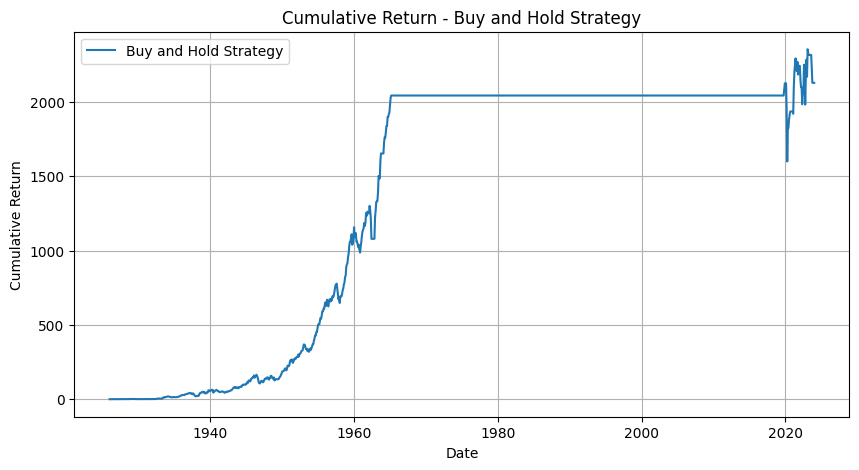

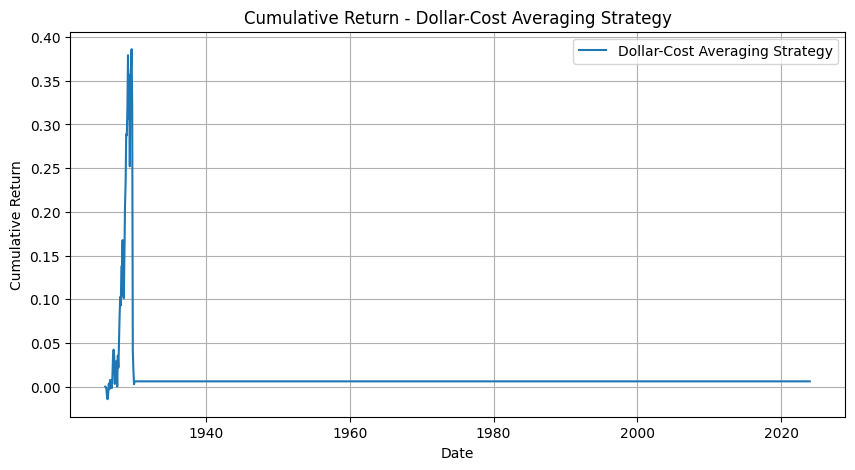

In [9]:
# Re-run strategies after fixes
bh_returns, bh_values = buy_and_hold_strategy(data)
dca_returns, dca_values = dca_strategy(data)
arima_returns, arima_values = arima_strategy(data)
lstm_returns, lstm_values = lstm_strategy(data)

# Compute performance metrics
bh_sharpe, bh_cum_returns, bh_max_dd = calculate_metrics(bh_returns, bh_values)
dca_sharpe, dca_cum_returns, dca_max_dd = calculate_metrics(dca_returns, dca_values)
arima_sharpe, arima_cum_returns, arima_max_dd = calculate_metrics(arima_returns, arima_values)
lstm_sharpe, lstm_cum_returns, lstm_max_dd = calculate_metrics(lstm_returns, lstm_values)

# Create results DataFrame
results = pd.DataFrame({
    'Strategy': ['Buy and Hold', 'DCA', 'ARIMA', 'LSTM'],
    'Sharpe Ratio': [bh_sharpe, dca_sharpe, arima_sharpe, lstm_sharpe],
    'Cumulative Return (%)': [bh_cum_returns, dca_cum_returns, arima_cum_returns, lstm_cum_returns],
    'Maximum Drawdown (%)': [bh_max_dd, dca_max_dd, arima_max_dd, lstm_max_dd]
})

# Display table in Jupyter Notebook
from IPython.display import display
display(results.round(2))

# Execute Buy and Hold Strategy and plot cumulative return
portfolio_returns, portfolio_values = buy_and_hold_strategy(data)
plot_cumulative_return(portfolio_values, "Buy and Hold Strategy")

# Execute DCA Strategy and plot cumulative return
portfolio_returns, portfolio_values = dca_strategy(data)
plot_cumulative_return(portfolio_values, "Dollar-Cost Averaging Strategy")


In [10]:
# Calculate performance metrics for each strategy
bh_sharpe, bh_cum_returns, bh_max_dd = calculate_metrics(bh_returns, bh_values)
dca_sharpe, dca_cum_returns, dca_max_dd = calculate_metrics(dca_returns, dca_values)
arima_sharpe, arima_cum_returns, arima_max_dd = calculate_metrics(arima_returns, arima_values)
lstm_sharpe, lstm_cum_returns, lstm_max_dd = calculate_metrics(lstm_returns, lstm_values)

# Create a DataFrame for easy comparison
results = pd.DataFrame({
    'Strategy': ['Buy and Hold', 'DCA', 'ARIMA', 'LSTM'],
    'Sharpe Ratio': [bh_sharpe, dca_sharpe, arima_sharpe, lstm_sharpe],
    'Cumulative Return (%)': [bh_cum_returns, dca_cum_returns, arima_cum_returns, lstm_cum_returns],
    'Maximum Drawdown (%)': [bh_max_dd, dca_max_dd, arima_max_dd, lstm_max_dd]
})

# Display the table in Jupyter Notebook
from IPython.display import display
display(results.round(2))


,Strategy,Sharpe Ratio,Cumulative Return (%),Maximum Drawdown (%)
0,Buy and Hold,0.80,212887.37,-52.91
1,DCA,0.02,0.60,-27.66
2,ARIMA,3.89,10414.55,-12.80
3,LSTM,NaN,NaN,NaN
